# Introduction

In this notebook we test a set of simple neural networks to predict crop yield from climate data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plotting

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-future-crop-challenge/pr_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_train.parquet
/kaggle/input/the-future-crop-challenge/sample_submission.csv
/kaggle/input/the-future-crop-challenge/soil_co2_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_train.parquet
/kaggle/input/the-future-crop-challenge/tasmin_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_test.parquet
/kaggle/input/the-future-crop-challenge/soil_co2_maize_test.parquet
/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_test.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_test.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_test.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_train.parquet
/kaggle/input/the-fu

## Dataset setup

We will try to train different architectures using pytorch. We spend some time here defining a dataset class.
This will let us train both recurrent networks and transformers later.

In [2]:
# Setup #
import os
import copy
import random
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DATA_DIR = r'/kaggle/input/the-future-crop-challenge'
print(f'Running on {device}')

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    return

setup_seed(2025) #set seed to current year

Running on cuda


In [3]:
class PredDataset(Dataset):
    """
    Optimized dataset class that processes data in bulk using vectorized operations
    and minimizes device transfers.
    """
    def __init__(self, crop: str, mode: str, data_dir: str, device=device):
        # Read all data files
        tasmax = pd.read_parquet(os.path.join(data_dir, f"tasmax_{crop}_{mode}.parquet"))
        tasmin = pd.read_parquet(os.path.join(data_dir, f"tasmin_{crop}_{mode}.parquet"))
        pr = pd.read_parquet(os.path.join(data_dir, f"pr_{crop}_{mode}.parquet"))
        rsds = pd.read_parquet(os.path.join(data_dir, f"rsds_{crop}_{mode}.parquet"))
        soil_co2 = pd.read_parquet(os.path.join(data_dir, f"soil_co2_{crop}_{mode}.parquet"))
        
        # Load yield data if in training mode
        if mode == 'train':
            self.yield_data = pd.read_parquet(os.path.join(data_dir, f"{mode}_solutions_{crop}.parquet"))
        else:
            self.yield_data = None
        # Preprocess climate data in bulk (shape: num_samples × 240 × 4)
        climate_data = np.stack([
            tasmax.iloc[:, 5:].values,
            tasmin.iloc[:, 5:].values,
            pr.iloc[:, 5:].values,
            rsds.iloc[:, 5:].values
        ], axis=2).astype(np.float32)
        
        # Preprocess soil data in bulk
        soil_continuous = soil_co2[['lon', 'lat', 'co2', 'nitrogen']].values.astype(np.float32)
        texture_classes = soil_co2['texture_class'].values.astype(np.int64) - 1
        texture_one_hot = np.eye(13)[texture_classes].astype(np.float32)  # One-hot encoding
        
        # Combine soil features (shape: num_samples × 17)
        soil_features = np.hstack([soil_continuous, texture_one_hot])
        
        # Expand soil features to match time dimension (shape: num_samples × 240 × 17)
        soil_expanded = np.repeat(soil_features[:, np.newaxis, :], 240, axis=1)
        
        # Combine climate and soil features (shape: num_samples × 240 × 21)
        full_input = np.concatenate([climate_data, soil_expanded], axis=2)
        
        # Move entire dataset to device in one operation
        self.inputs = torch.tensor(full_input, device=device)
        
        # Process targets if available
        self.targets = None
        if self.yield_data is not None:
            self.targets = torch.tensor(
                self.yield_data.values.astype(np.float32), 
                device=device
            )

    def __getitem__(self, index):
        # Return precomputed tensors
        return self.inputs[index], self.targets[index]

    def __len__(self):
        return len(self.inputs)

print('Loading training data.,. (this may take a while)')
ds_wheat = PredDataset('wheat','train', DATA_DIR)

#train_wheat = torch.utils.data.subset

#print('Loading test data... (this may take a while)')
#wheat_test = PredDataset('wheat','test', DATA_DIR, device = 'cpu')

print('Finished loading')

Loading training data.,. (this may take a while)
Finished loading


In [4]:
n_train = int(len(ds_wheat.inputs)*0.8)
n_val = len(ds_wheat.inputs)-n_train

train_wheat = torch.utils.data.Subset(ds_wheat, range(n_train))
val_wheat = torch.utils.data.Subset(ds_wheat,range(n_train,n_train+n_val))

## simple RNN class

Here's an example of a very simple RNN. As an auxilliary loss (hidden weight regularisation), we also try to predict the next crop data.

In [8]:
# define model #

class PredictiveRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_targets, n_layers, nonlinearity = 'relu'):
        super(PredictiveRNN, self).__init__()
        self.n_hidden = n_hidden
        self.n_inputs = n_inputs
        self.n_targets = n_targets
        self.n_layers = n_layers

        self.rnn = nn.GRU(n_inputs, n_hidden, n_layers,
                          batch_first = True)
        self.encoder = nn.Linear(n_inputs, n_hidden*n_layers)
        self.decoder = nn.Linear(n_hidden, n_targets)
        self.mse = nn.MSELoss()

        #initialise weights for improved gradient descent
        for name, param in self.named_parameters():
            if 'weight' in name:
                if nonlinearity == 'tanh':
                    nn.init.xavier_uniform_(param)
                elif nonlinearity == 'relu':
                    nn.init.kaiming_uniform_(param)           
        
    def forward(self, inputs):
        #we want to initialise the hidden state with encoder weights rather than 0s
        #these are esentially context-setting weights.
        h0 = self.encoder(inputs[:,0,:])
        h0 = h0.reshape(self.n_layers,inputs.shape[0],self.n_hidden) #(1,batch_size,1)
       
        rnn_out, hidden = self.rnn(inputs, h0)
        predictions = self.decoder(rnn_out)

        return predictions, rnn_out

    def compute_losses(self, predictions, climate_targets, yield_target):
        pred_loss = self.mse(predictions[:,:-1,:self.n_targets-1], #(n_batches, n_seq-1, n_targets-1 ) aligned to time t
                             climate_targets[:,1:,:self.n_targets-1]) #(n_batches, n_seq-1, n_targets-1 ) aligned to time t+1
        yield_loss = self.mse(predictions[:,-2:-1,-1], yield_target.expand(predictions[:,-2:-1,-1].shape)) #(n_batches,240,1)
        return pred_loss, yield_loss

In [69]:
# Training loop #

# global variables / options #
BATCH_SIZE = 100
N_EPOCHS = 2
LEARNING_RATE = 1e-2
N_HIDDEN = 512
N_LAYERS = 1
N_INPUT = 4+17 #4 climate datapoints, 17 soil datapoints (one-hot)
N_TARGET = 4+1 #4 climate datapoints + crop yield

# set up model and optimizer # 
model = PredictiveRNN(N_INPUT, N_HIDDEN, N_TARGET,N_LAYERS,
                     nonlinearity = 'tanh').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, amsgrad=True)

# prepare data loader and start training loop #

train_loader = DataLoader(train_wheat, batch_size= BATCH_SIZE, shuffle=True)
test_loader = DataLoader(val_wheat, batch_size= BATCH_SIZE, shuffle=False)
print('train loader success')
def train_model(train_loader, model, optimizer):
    losses = {'train_or_test':[],'pred':[], 'yield':[],'epoch':[],'idx':[]}
    for epoch in range(N_EPOCHS):
        for i, (inputs, targets) in tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
            #run data through model and backprop losses
            predictions, _ = model(inputs)
            pred_loss, yield_loss = model.compute_losses(predictions, inputs, targets)
            loss = pred_loss+yield_loss
            loss.backward()
            optimizer.step()
            #append losses
            losses['train_or_test'].append('train')
            losses['epoch'].append(epoch)
            losses['yield'].append(yield_loss.detach().cpu().item())
            losses['pred'].append(pred_loss.detach().cpu().item())
            losses['idx'].append(i)
            #print(f'Prediction loss: {round(prediction_losses[-1],3)}, yield loss: {round(yield_losses[-1],3)}')

        with torch.no_grad():
            for i, (inputs, targets) in tqdm(enumerate(test_loader)):
                predictions, _  =model(inputs)
                pred_loss, yield_loss = model.compute_losses(predictions, inputs, targets)
                losses['train_or_test'].append('test')
                losses['epoch'].append(epoch)
                losses['yield'].append(yield_loss.detach().cpu().item())
                losses['pred'].append(pred_loss.detach().cpu().item())
                losses['idx'].append(i)

    return model, losses

model, losses = train_model(train_loader, model,optimizer)



train loader success


2230it [02:11, 16.92it/s]
558it [00:13, 42.21it/s]
2230it [02:09, 17.20it/s]
558it [00:13, 42.12it/s]


In [74]:
loss_df.groupby(['epoch','train_or_test']).mean('yield')

pred      yield     idx
epoch train_or_test                               
0     test           500.091660   2.715062   278.5
      train          611.086898  20.362136  1114.5
1     test           466.304636   1.829468   278.5
      train          480.478830   2.076788  1114.5

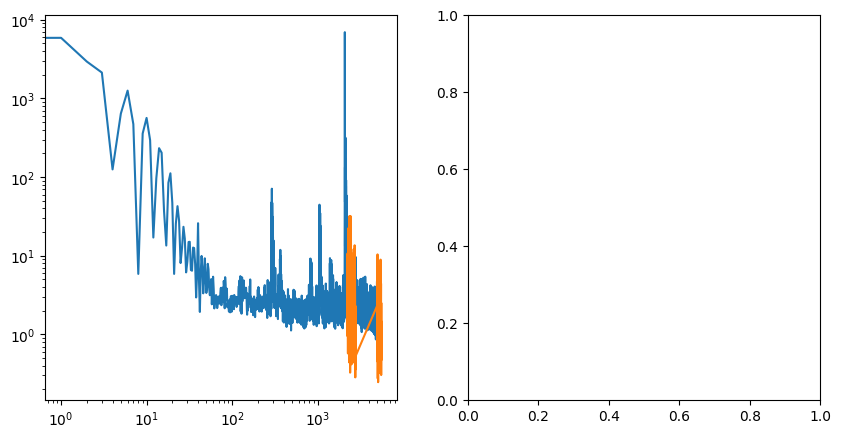

In [75]:
loss_df = pd.DataFrame(losses)
grouped_df = loss_df.groupby(['epoch','train_or_test']).mean('yield')
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].loglog(loss_df.query('train_or_test == "train"')['yield'])
ax[0].loglog(loss_df.query('train_or_test == "test"')['yield'])

Note: I've tested different network sizes and 2 layers.

Larger and deeper networks take longer to train and don't seem to have much different performance. The current estimate of yield loss varies around 1.5

That said, we should do a better estimate of network performance using cross-validated held-out data from the last few years of the dataset (having to generalise to unseen data with higher CO2 concentrations, as in the actual test of the competition).

I've also tried GRU's and LSTMs with size 512, these obtaining yield losses varying around [1.2] (prediction loss round 360)


In [ ]:
fix, ax  = plt.subplots(1,2)
ax[0].loglog(yield_losses)
ax[1].loglog(prediction_losses)

In [ ]:
## Make sure the code is as efficient as can be:
# %load_ext line_profiler
# %lprun -f train_model train_model(train_loader, model,optimizer)

## Training transformers

Assuming this will have larger memory demands, though.

I've asked claude to make a flexible PredNet class

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math



class FlexiblePredNet(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_targets, n_layers, 
                 model_type='gru', nonlinearity='tanh', 
                 n_heads=8, dropout=0.1, sequence_length=None):
        """
        Flexible predictive network supporting RNN, GRU, and Transformer architectures
        
        Args:
            n_inputs: Input feature dimension per timestep
            n_hidden: Hidden dimension
            n_targets: Output target dimension per timestep
            n_layers: Number of layers
            model_type: 'rnn', 'gru', or 'transformer'
            nonlinearity: 'tanh' or 'relu' (for RNN/GRU)
            n_heads: Number of attention heads (for transformer)
            dropout: Dropout rate (for transformer)
            sequence_length: Required for transformer - length of input sequences
        """
        super(FlexiblePredNet, self).__init__()
        self.n_hidden = n_hidden
        self.n_inputs = n_inputs
        self.n_targets = n_targets
        self.n_layers = n_layers
        self.model_type = model_type.lower()
        self.sequence_length = sequence_length
        
        # Model-specific components
        if self.model_type == 'rnn':
            # Input projection to hidden dimension (per timestep)
            self.input_projection = nn.Linear(n_inputs, n_hidden)
            self.sequence_model = nn.RNN(n_hidden, n_hidden, n_layers,
                                       batch_first=True, nonlinearity=nonlinearity)
            self.encoder = nn.Linear(n_inputs, n_hidden * n_layers)
            # Output projection (per timestep)
            self.decoder = nn.Linear(n_hidden, n_targets)
            
        elif self.model_type == 'gru':
            # Input projection to hidden dimension (per timestep)
            self.input_projection = nn.Linear(n_inputs, n_hidden)
            self.sequence_model = nn.GRU(n_hidden, n_hidden, n_layers,
                                       batch_first=True)
            self.encoder = nn.Linear(n_inputs, n_hidden * n_layers)
            # Output projection (per timestep)
            self.decoder = nn.Linear(n_hidden, n_targets)
            
        elif self.model_type == 'transformer':
            if sequence_length is None:
                raise ValueError("sequence_length must be provided for transformer model")
            
            # Calculate flattened input size: sequence_length * climate_features + soil_features
            # Assuming last 17 features are soil (one-hot), first 4 are climate per timestep
            climate_features = n_inputs - 17  # 4 climate features
            soil_features = 17  # 17 soil features
            flattened_input_size = sequence_length * climate_features + soil_features
            
            # Input projection to transformer dimension
            self.input_projection = nn.Linear(flattened_input_size, n_hidden)
            
            # Standard transformer encoder
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=n_hidden,
                nhead=n_heads,
                dim_feedforward=n_hidden //2,
                dropout=dropout,
                activation='relu',
                batch_first=True
            )
            self.sequence_model = nn.TransformerEncoder(encoder_layer, n_layers)
            
            # Output projection to full sequence
            self.decoder = nn.Linear(n_hidden, sequence_length * n_targets)
            
        else:
            raise ValueError(f"Unsupported model_type: {model_type}. Choose from 'rnn', 'gru', 'transformer'")
        
        self.mse = nn.MSELoss()
        
        # Initialize weights
        if model_type != 'transformer':
            self._initialize_weights(nonlinearity)
        
    def _initialize_weights(self, nonlinearity):
        """Initialize model weights"""
        for name, param in self.named_parameters():
            if 'weight' in name and 'decoder' not in name:
                if nonlinearity == 'tanh':
                    nn.init.xavier_uniform_(param)
                elif nonlinearity == 'relu':
                    nn.init.kaiming_uniform_(param)
                else:
                    nn.init.xavier_uniform_(param)  # Default for transformer
                    
    def _create_causal_mask(self, seq_len, device):
        """Create causal (lower triangular) mask for transformer"""
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask
        
    def forward(self, inputs):
        batch_size, seq_len, input_dim = inputs.shape
        
        if self.model_type in ['rnn', 'gru']:
            # Project inputs to hidden dimension
            projected_inputs = self.input_projection(inputs)
            
            # Initialize hidden state with encoder weights (like your original)
            h0 = self.encoder(inputs[:, 0, :])
            h0 = h0.reshape(self.n_layers, batch_size, self.n_hidden)
            
            # Run through RNN/GRU
            sequence_out, hidden = self.sequence_model(projected_inputs, h0)
            
            # Decode to output dimension
            predictions = self.decoder(sequence_out)
            return predictions, sequence_out
            
        elif self.model_type == 'transformer':
            # Flatten the sequence for transformer
            # Split climate (first 4 features per timestep) and soil (last 17 features)
            climate_features = 4
            soil_features = 17
            
            # Extract climate features from all timesteps: (batch, seq_len, 4)
            climate_data = inputs[:, :, :climate_features]  
            # Extract soil features from last timestep: (batch, 17)
            soil_data = inputs[:, -1, climate_features:]  
            
            # Flatten climate data: (batch, seq_len * 4)
            flattened_climate = climate_data.reshape(batch_size, -1)
            
            # Concatenate flattened climate with soil: (batch, seq_len * 4 + 17)
            flattened_input = torch.cat([flattened_climate, soil_data], dim=1)
            
            # Project to transformer dimension and add sequence dimension for transformer
            # Transformer expects (batch, seq, features), so we add a dummy sequence dimension
            projected_input = self.input_projection(flattened_input).unsqueeze(1)  # (batch, 1, hidden)
            
            # Create causal mask (though with seq_len=1, this is not strictly needed)
            causal_mask = self._create_causal_mask(1, inputs.device)
            
            # Pass through transformer
            transformer_out = self.sequence_model(projected_input, mask=causal_mask)  # (batch, 1, hidden)
            
            # Decode to full sequence output
            flat_predictions = self.decoder(transformer_out.squeeze(1))  # (batch, seq_len * n_targets)
            
            # Reshape back to sequence format: (batch, seq_len, n_targets)
            predictions = flat_predictions.reshape(batch_size, seq_len, self.n_targets)
            
            return predictions, transformer_out.squeeze(1)
    
    def compute_losses(self, predictions, climate_targets, yield_target):
        """Compute prediction and yield losses with causal masking for loss computation"""
        if self.model_type in ['rnn', 'gru']:
            # Original loss computation for RNN/GRU
            pred_loss = self.mse(predictions[:, :-1, :self.n_targets-1], 
                               climate_targets[:, 1:, :self.n_targets-1])
            yield_loss = self.mse(predictions[:, -2:-1, -1], 
                                yield_target.expand(predictions[:, -2:-1, -1].shape))
        
        elif self.model_type == 'transformer':
            # For transformer, we can apply causal masking to the loss computation
            # This ensures we only compute loss where we should have predictions
            batch_size, seq_len, _ = predictions.shape
            
            # Create causal mask for loss computation
            causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=predictions.device))
            
            # Compute prediction loss with causal masking
            pred_losses = []
            for t in range(1, seq_len):  # Start from 1 since we predict t+1 from t
                # At timestep t, we can predict based on timesteps 0 to t-1
                pred_at_t = predictions[:, t-1:t, :self.n_targets-1]  # Prediction made at t-1
                target_at_t = climate_targets[:, t:t+1, :self.n_targets-1]  # Target at t
                pred_losses.append(self.mse(pred_at_t, target_at_t))
            
            pred_loss = torch.stack(pred_losses).mean()
            
            # Yield loss (predict from second-to-last timestep)
            yield_loss = self.mse(predictions[:, -2:-1, -1], 
                                yield_target.expand(predictions[:, -2:-1, -1].shape))
        
        return pred_loss, yield_loss

# Updated training function with model type logging
def train_model(train_loader, val_loader, model, optimizer, n_epochs, model_type):
    losses  = {'train':{'yield':[],'pred':[]},'val':{'yield':[],'pred':[]}}
    
    print(f"Training {model_type.upper()} model...")
    
    for epoch in range(n_epochs):
        epoch_yield_losses = []
        epoch_pred_losses = []
        
        for i, (inputs, targets) in tqdm(enumerate(train_loader), 
                                        desc=f"Epoch {epoch+1}/{n_epochs}"):
            optimizer.zero_grad()
            
            # Run data through model and backprop losses
            predictions, _ = model(inputs)
            pred_loss, yield_loss = model.compute_losses(predictions, inputs, targets)
            loss = yield_loss # + 1e-2*pred_loss
            loss.backward()
            optimizer.step()
            
            # Append losses
            epoch_yield_losses.append(yield_loss.detach().cpu().item())
            epoch_pred_losses.append(pred_loss.detach().cpu().item())
        
        # Store epoch averages
        losses['train']['yield'].extend(epoch_yield_losses)
        losses['train']['pred'].extend(epoch_pred_losses)
        
        avg_pred = sum(epoch_pred_losses) / len(epoch_pred_losses)
        avg_yield = sum(epoch_yield_losses) / len(epoch_yield_losses)

        if (epoch % 10) == 0:   
            val_yield_losses = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in val_loader:
                # Run data through model and backprop losses
                    predictions, _ = model(inputs)
                    pred_loss, yield_loss = model.compute_losses(predictions, inputs, targets)
                    val_yield_losses.append(yield_loss.item())
            val_yield = np.mean(val_yield_losses)
            losses['val']['yield'].extend(val_yield_losses)
            print(f'Epoch {epoch+1}: Prediction loss: {avg_pred:.3f}, Yield loss: {avg_yield:.3f} \n Val loss: {val_yield:.3f}')
            
    return model, losses

# Usage example with different model types
def train_and_compare_models(train_loader, val_loader, device, n_epochs=10):
    """Train and compare different model architectures"""
    results = {}
    model_configs = [
        #{'type': 'rnn', 'nonlinearity': 'tanh'},
        {'type': 'transformer', 'dropout': 0.2},
       # {'type': 'gru', 'nonlinearity': 'tanh'},
    ]
    
    for config in model_configs:
        print(f"\n{'='*50}")
        model_type = config['type']
        print(f"Training {model_type.upper()} model")
        print(f"{'='*50}")
        
        # Create model
        if model_type == 'transformer':
            model = FlexiblePredNet(
                N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                model_type=model_type,
                dropout=config['dropout'],
                sequence_length=240  # You'll need to set this to your actual sequence length
            ).to(device)
        else:
            model = FlexiblePredNet(
                N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                model_type=model_type,
                nonlinearity=config['nonlinearity']
            ).to(device)
        
        # Create optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, 
                                      amsgrad=True, weight_decay = 1e-3)
        
        # Train model
        trained_model, losses = train_model(
            train_loader,val_loader, model, optimizer, n_epochs, model_type
        )
        
        results[model_type] = {
            'model': trained_model,
            'losses': losses
        }
    
    return results

# Simple usage example for single model
if __name__ == "__main__":
    # Example usage - replace with your actual data loader and device
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Global variables / options
    BATCH_SIZE = 100
    N_EPOCHS = 100
    LEARNING_RATE = 3e-4
    N_HIDDEN = 128
    N_LAYERS = 2
    N_INPUT = 4 + 17  # 4 climate datapoints, 17 soil datapoints (one-hot)
    N_TARGET = 4 + 1  # 4 climate datapoints + crop yield
    
    # Example: Create a GRU model (same as your original)
    model_gru = FlexiblePredNet(N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                               model_type='gru', nonlinearity='tanh')
    
    # Example: Create a Transformer model without positional encoding
    model_transformer = FlexiblePredNet(N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                                      model_type='transformer', dropout=0.1, 
                                      sequence_length=240)  # Specify your sequence length
    
    # Example: Create an RNN model
    model_rnn = FlexiblePredNet(N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                              model_type='rnn', nonlinearity='tanh')
    
    print("Models created successfully!")
    print(f"GRU parameters: {sum(p.numel() for p in model_gru.parameters()):,}")
    print(f"Transformer parameters: {sum(p.numel() for p in model_transformer.parameters()):,}")
    print(f"RNN parameters: {sum(p.numel() for p in model_rnn.parameters()):,}")

Models created successfully!
GRU parameters: 207,237
Transformer parameters: 446,256
RNN parameters: 75,141


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math


class RevIN(nn.Module):
    """
    Reversible Instance Normalization for time series
    Normalizes input by instance statistics, then denormalizes output
    """
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        
        if self.affine:
            self.affine_weight = nn.Parameter(torch.ones(num_features))
            self.affine_bias = nn.Parameter(torch.zeros(num_features))
    
    def forward(self, x, mode='norm'):
        """
        Args:
            x: Input tensor of shape (batch, seq_len, features)
            mode: 'norm' for normalization, 'denorm' for denormalization
        """
        if mode == 'norm':
            # Store statistics for denormalization
            self._get_statistics(x)
            # Normalize
            x = x - self.mean
            x = x / (self.stdev + self.eps)
            
            if self.affine:
                x = x * self.affine_weight
                x = x + self.affine_bias
            return x
            
        elif mode == 'denorm':
            # Denormalize
            if self.affine:
                x = x - self.affine_bias
                x = x / (self.affine_weight + self.eps * self.eps)
            
            x = x * (self.stdev + self.eps)
            x = x + self.mean
            return x
        else:
            raise NotImplementedError(f"Mode {mode} not supported")
    
    def _get_statistics(self, x):
        """Compute mean and stdev across sequence length dimension"""
        # x shape: (batch, seq_len, features)
        # Compute statistics along sequence dimension (dim=1)
        self.mean = torch.mean(x, dim=1, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + self.eps).detach()


class FlexiblePredNet(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_targets, n_layers, 
                 model_type='gru', nonlinearity='tanh', 
                 n_heads=8, dropout=0.1, sequence_length=None,
                 use_revin=True, revin_affine=True):
        """
        Flexible predictive network supporting RNN, GRU, and Transformer architectures
        
        Args:
            n_inputs: Input feature dimension per timestep
            n_hidden: Hidden dimension
            n_targets: Output target dimension per timestep
            n_layers: Number of layers
            model_type: 'rnn', 'gru', or 'transformer'
            nonlinearity: 'tanh' or 'relu' (for RNN/GRU)
            n_heads: Number of attention heads (for transformer)
            dropout: Dropout rate (for transformer)
            sequence_length: Required for transformer - length of input sequences
            use_revin: Whether to use Reversible Instance Normalization
            revin_affine: Whether to use affine transformation in RevIN
        """
        super(FlexiblePredNet, self).__init__()
        self.n_hidden = n_hidden
        self.n_inputs = n_inputs
        self.n_targets = n_targets
        self.n_layers = n_layers
        self.model_type = model_type.lower()
        self.sequence_length = sequence_length
        self.use_revin = use_revin
        
        # RevIN for climate features only (first 4 features)
        # We don't normalize soil features since they're one-hot encoded
        if self.use_revin:
            self.revin_climate = RevIN(4, affine=revin_affine)  # Only for 4 climate features
        
        # Model-specific components
        if self.model_type == 'rnn':
            # Input projection to hidden dimension (per timestep)
            self.input_projection = nn.Linear(n_inputs, n_hidden)
            self.sequence_model = nn.RNN(n_hidden, n_hidden, n_layers,
                                       batch_first=True, nonlinearity=nonlinearity)
            self.encoder = nn.Linear(n_inputs, n_hidden * n_layers)
            # Output projection (per timestep)
            self.decoder = nn.Linear(n_hidden, n_targets)
            
        elif self.model_type == 'gru':
            # Input projection to hidden dimension (per timestep)
            self.input_projection = nn.Linear(n_inputs, n_hidden)
            self.sequence_model = nn.GRU(n_hidden, n_hidden, n_layers,
                                       batch_first=True)
            self.encoder = nn.Linear(n_inputs, n_hidden * n_layers)
            # Output projection (per timestep)
            self.decoder = nn.Linear(n_hidden, n_targets)
            
        elif self.model_type == 'transformer':
            if sequence_length is None:
                raise ValueError("sequence_length must be provided for transformer model")
            
            # Calculate flattened input size: sequence_length * climate_features + soil_features
            # Assuming last 17 features are soil (one-hot), first 4 are climate per timestep
            climate_features = n_inputs - 17  # 4 climate features
            soil_features = 17  # 17 soil features
            flattened_input_size = sequence_length * climate_features + soil_features
            
            # Input projection to transformer dimension
            self.input_projection = nn.Linear(flattened_input_size, n_hidden)
            
            # Standard transformer encoder
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=n_hidden,
                nhead=n_heads,
                dim_feedforward=n_hidden // 2,  # 0.5x bottleneck ratio
                dropout=dropout,
                activation='relu',
                batch_first=True
            )
            self.sequence_model = nn.TransformerEncoder(encoder_layer, n_layers)
            
            # Output projection to full sequence
            self.decoder = nn.Linear(n_hidden, sequence_length * n_targets)
            
        else:
            raise ValueError(f"Unsupported model_type: {model_type}. Choose from 'rnn', 'gru', 'transformer'")
        
        self.mse = nn.MSELoss()
        
        # Initialize weights
        if model_type != 'transformer':
            self._initialize_weights(nonlinearity)
        
    def _initialize_weights(self, nonlinearity):
        """Initialize model weights"""
        for name, param in self.named_parameters():
            # Skip RevIN parameters and 1D tensors
            if 'revin' in name or param.dim() < 2:
                continue
            if 'weight' in name and 'decoder' not in name:
                if nonlinearity == 'tanh':
                    nn.init.xavier_uniform_(param)
                elif nonlinearity == 'relu':
                    nn.init.kaiming_uniform_(param)
                else:
                    nn.init.xavier_uniform_(param)  # Default for transformer
                    
    def _create_causal_mask(self, seq_len, device):
        """Create causal (lower triangular) mask for transformer"""
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask
        
    def forward(self, inputs):
        batch_size, seq_len, input_dim = inputs.shape
        
        # Apply RevIN to climate features if enabled
        if self.use_revin:
            # Split climate and soil features
            climate_features = inputs[:, :, :4]  # First 4 features
            soil_features = inputs[:, :, 4:]     # Last 17 features
            
            # Normalize climate features
            climate_normalized = self.revin_climate(climate_features, mode='norm')
            
            # Recombine
            inputs = torch.cat([climate_normalized, soil_features], dim=-1)
        
        if self.model_type in ['rnn', 'gru']:
            # Project inputs to hidden dimension
            projected_inputs = self.input_projection(inputs)
            
            # Initialize hidden state with encoder weights (like your original)
            h0 = self.encoder(inputs[:, 0, :])
            h0 = h0.reshape(self.n_layers, batch_size, self.n_hidden)
            
            # Run through RNN/GRU
            sequence_out, hidden = self.sequence_model(projected_inputs, h0)
            
            # Decode to output dimension
            predictions = self.decoder(sequence_out)
            
            # Denormalize climate predictions if RevIN is enabled
            if self.use_revin:
                # Split predictions into climate and yield
                climate_predictions = predictions[:, :, :4]  # First 4 features
                yield_predictions = predictions[:, :, 4:]    # Last feature (yield)
                
                # Denormalize climate predictions
                climate_denormalized = self.revin_climate(climate_predictions, mode='denorm')
                
                # Recombine
                predictions = torch.cat([climate_denormalized, yield_predictions], dim=-1)
            
            return predictions, sequence_out
            
        elif self.model_type == 'transformer':
            # Flatten the sequence for transformer
            # Split climate (first 4 features per timestep) and soil (last 17 features)
            climate_features = 4
            soil_features = 17
            
            # Extract climate features from all timesteps: (batch, seq_len, 4)
            climate_data = inputs[:, :, :climate_features]  
            # Extract soil features from last timestep: (batch, 17)
            soil_data = inputs[:, -1, climate_features:]  
            
            # Flatten climate data: (batch, seq_len * 4)
            flattened_climate = climate_data.reshape(batch_size, -1)
            
            # Concatenate flattened climate with soil: (batch, seq_len * 4 + 17)
            flattened_input = torch.cat([flattened_climate, soil_data], dim=1)
            
            # Project to transformer dimension and add sequence dimension for transformer
            # Transformer expects (batch, seq, features), so we add a dummy sequence dimension
            projected_input = self.input_projection(flattened_input).unsqueeze(1)  # (batch, 1, hidden)
            
            # Create causal mask (though with seq_len=1, this is not strictly needed)
            causal_mask = self._create_causal_mask(1, inputs.device)
            
            # Pass through transformer
            transformer_out = self.sequence_model(projected_input, mask=causal_mask)  # (batch, 1, hidden)
            
            # Decode to full sequence output
            flat_predictions = self.decoder(transformer_out.squeeze(1))  # (batch, seq_len * n_targets)
            
            # Reshape back to sequence format: (batch, seq_len, n_targets)
            predictions = flat_predictions.reshape(batch_size, seq_len, self.n_targets)
            
            # Denormalize climate predictions if RevIN is enabled
            if self.use_revin:
                # Split predictions into climate and yield
                climate_predictions = predictions[:, :, :4]  # First 4 features
                yield_predictions = predictions[:, :, 4:]    # Last feature (yield)
                
                # Denormalize climate predictions
                climate_denormalized = self.revin_climate(climate_predictions, mode='denorm')
                
                # Recombine
                predictions = torch.cat([climate_denormalized, yield_predictions], dim=-1)
            
            return predictions, transformer_out.squeeze(1)
    
    def compute_losses(self, predictions, climate_targets, yield_target):
        """Compute prediction and yield losses with causal masking for loss computation"""
        if self.model_type in ['rnn', 'gru']:
            # Original loss computation for RNN/GRU
            pred_loss = self.mse(predictions[:, :-1, :self.n_targets-1], 
                               climate_targets[:, 1:, :self.n_targets-1])
            yield_loss = self.mse(predictions[:, -2:-1, -1], 
                                yield_target.expand(predictions[:, -2:-1, -1].shape))
        
        elif self.model_type == 'transformer':
            # For transformer, we can apply causal masking to the loss computation
            # This ensures we only compute loss where we should have predictions
            batch_size, seq_len, _ = predictions.shape
            
            # Create causal mask for loss computation
            causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=predictions.device))
            
            # Compute prediction loss with causal masking
            pred_losses = []
            for t in range(1, seq_len):  # Start from 1 since we predict t+1 from t
                # At timestep t, we can predict based on timesteps 0 to t-1
                pred_at_t = predictions[:, t-1:t, :self.n_targets-1]  # Prediction made at t-1
                target_at_t = climate_targets[:, t:t+1, :self.n_targets-1]  # Target at t
                pred_losses.append(self.mse(pred_at_t, target_at_t))
            
            pred_loss = torch.stack(pred_losses).mean()
            
            # Yield loss (predict from second-to-last timestep)
            yield_loss = self.mse(predictions[:, -2:-1, -1], 
                                yield_target.expand(predictions[:, -2:-1, -1].shape))
        
        return pred_loss, yield_loss


# Updated training function with model type logging
def train_model(train_loader, model, optimizer, n_epochs, model_type):
    yield_losses = []
    prediction_losses = []
    
    print(f"Training {model_type.upper()} model...")
    
    for epoch in range(n_epochs):
        epoch_yield_losses = []
        epoch_pred_losses = []
        
        for i, (inputs, targets) in tqdm(enumerate(train_loader), 
                                        desc=f"Epoch {epoch+1}/{n_epochs}"):
            optimizer.zero_grad()
            
            # Run data through model and backprop losses
            predictions, _ = model(inputs)
            pred_loss, yield_loss = model.compute_losses(predictions, inputs, targets)
            loss = yield_loss # + 1e-2*pred_loss
            loss.backward()
            optimizer.step()
            
            # Append losses
            epoch_yield_losses.append(yield_loss.detach().cpu().item())
            epoch_pred_losses.append(pred_loss.detach().cpu().item())
            
        # Store epoch averages
        yield_losses.extend(epoch_yield_losses)
        prediction_losses.extend(epoch_pred_losses)
        
        avg_pred = sum(epoch_pred_losses) / len(epoch_pred_losses)
        avg_yield = sum(epoch_yield_losses) / len(epoch_yield_losses)
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}: Prediction loss: {avg_pred:.3f}, Yield loss: {avg_yield:.3f}')
    
    return model, yield_losses, prediction_losses


# Usage example with different model types
def train_and_compare_models(train_loader, device, n_epochs=10):
    """Train and compare different model architectures"""
    
    results = {}
    
    model_configs = [
        {'type': 'transformer', 'dropout': 0.2, 'use_revin': True},
        {'type': 'transformer', 'dropout': 0.2, 'use_revin': False},  # For comparison
    ]
    
    for config in model_configs:
        print(f"\n{'='*50}")
        model_type = config['type']
        use_revin = config.get('use_revin', True)
        print(f"Training {model_type.upper()} model (RevIN: {use_revin})")
        print(f"{'='*50}")
        
        # Create model
        if model_type == 'transformer':
            model = FlexiblePredNet(
                N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                model_type=model_type,
                dropout=config['dropout'],
                sequence_length=240,
                use_revin=use_revin
            ).to(device)
        else:
            model = FlexiblePredNet(
                N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                model_type=model_type,
                nonlinearity=config['nonlinearity'],
                use_revin=use_revin
            ).to(device)
        
        # Create optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, amsgrad=True)
        
        # Train model
        trained_model, yield_losses, prediction_losses = train_model(
            train_loader, model, optimizer, n_epochs, model_type
        )
        
        config_name = f"{model_type}_revin_{use_revin}"
        results[config_name] = {
            'model': trained_model,
            'yield_losses': yield_losses,
            'prediction_losses': prediction_losses
        }
    
    return results


# Simple usage example for single model
if __name__ == "__main__":
    # Example usage - replace with your actual data loader and device
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Global variables / options
    BATCH_SIZE = 100
    N_EPOCHS = 100
    LEARNING_RATE = 1e-2
    N_HIDDEN = 32
    N_LAYERS = 2
    N_INPUT = 4 + 17  # 4 climate datapoints, 17 soil datapoints (one-hot)
    N_TARGET = 4 + 1  # 4 climate datapoints + crop yield
    
    # Example: Create a GRU model with RevIN
    model_gru = FlexiblePredNet(N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                               model_type='gru', nonlinearity='tanh',
                               use_revin=True)
    
    # Example: Create a Transformer model with RevIN and bottleneck MLP
    model_transformer = FlexiblePredNet(N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                                      model_type='transformer', dropout=0.1, 
                                      sequence_length=240,
                                      use_revin=True)
    
    # Example: Create an RNN model without RevIN (for comparison)
    model_rnn = FlexiblePredNet(N_INPUT, N_HIDDEN, N_TARGET, N_LAYERS,
                              model_type='rnn', nonlinearity='tanh',
                              use_revin=False)
    
    print("Models created successfully!")
    print(f"GRU parameters: {sum(p.numel() for p in model_gru.parameters()):,}")
    print(f"Transformer parameters: {sum(p.numel() for p in model_transformer.parameters()):,}")
    print(f"RNN parameters: {sum(p.numel() for p in model_rnn.parameters()):,}")

Models created successfully!
GRU parameters: 14,957
Transformer parameters: 81,752
RNN parameters: 6,501


In [20]:
train_loader = DataLoader(train_wheat, batch_size = 2**10, shuffle = True)
val_loader = DataLoader(val_wheat, batch_size = 512, shuffle = False)

results = train_and_compare_models(train_loader, 'cuda', n_epochs=20)


Training TRANSFORMER model (RevIN: True)
Training TRANSFORMER model...


Epoch 1/20: 218it [00:08, 25.42it/s]


Epoch 1: Prediction loss: 2287.669, Yield loss: 1.959


Epoch 2/20: 218it [00:08, 25.98it/s]
Epoch 3/20: 218it [00:08, 25.50it/s]
Epoch 4/20: 218it [00:08, 26.01it/s]
Epoch 5/20: 218it [00:08, 26.01it/s]
Epoch 6/20: 218it [00:08, 25.48it/s]
Epoch 7/20: 218it [00:08, 26.04it/s]
Epoch 8/20: 218it [00:08, 25.35it/s]
Epoch 9/20: 218it [00:08, 26.08it/s]
Epoch 10/20: 218it [00:08, 26.30it/s]
Epoch 11/20: 218it [00:08, 25.75it/s]


Epoch 11: Prediction loss: 1591.380, Yield loss: 0.914


Epoch 12/20: 218it [00:08, 26.27it/s]
Epoch 13/20: 218it [00:08, 26.19it/s]
Epoch 14/20: 218it [00:08, 25.82it/s]
Epoch 15/20: 218it [00:08, 26.11it/s]
Epoch 16/20: 218it [00:08, 26.17it/s]
Epoch 17/20: 218it [00:08, 25.67it/s]
Epoch 18/20: 218it [00:08, 26.33it/s]
Epoch 19/20: 218it [00:08, 26.27it/s]
Epoch 20/20: 218it [00:08, 25.79it/s]



Training TRANSFORMER model (RevIN: False)
Training TRANSFORMER model...


Epoch 1/20: 218it [00:07, 27.69it/s]


Epoch 1: Prediction loss: 5813.961, Yield loss: 2.564


Epoch 2/20: 218it [00:07, 28.10it/s]
Epoch 3/20: 218it [00:07, 27.76it/s]
Epoch 4/20: 218it [00:07, 28.11it/s]
Epoch 5/20: 218it [00:08, 27.04it/s]
Epoch 6/20: 218it [00:08, 25.78it/s]
Epoch 7/20: 218it [00:08, 26.38it/s]
Epoch 8/20: 218it [00:08, 26.02it/s]
Epoch 9/20: 218it [00:08, 25.50it/s]
Epoch 10/20: 218it [00:08, 26.17it/s]
Epoch 11/20: 218it [00:08, 25.95it/s]


Epoch 11: Prediction loss: 5815.315, Yield loss: 1.510


Epoch 12/20: 218it [00:08, 26.34it/s]
Epoch 13/20: 218it [00:08, 26.37it/s]
Epoch 14/20: 218it [00:08, 25.81it/s]
Epoch 15/20: 218it [00:08, 26.42it/s]
Epoch 16/20: 218it [00:08, 26.16it/s]
Epoch 17/20: 218it [00:08, 25.54it/s]
Epoch 18/20: 218it [00:08, 26.07it/s]
Epoch 19/20: 218it [00:08, 26.31it/s]
Epoch 20/20: 218it [00:08, 26.39it/s]


In [15]:
results.keys()

dict_keys(['transformer_revin_True', 'transformer_revin_False'])

In [12]:
print(min(results['transformer']['losses']['train']['yield']),max(results['transformer']['losses']['train']['yield'][-100:]))
fig, ax = plt.subplots(1,2, sharey=True)
ax[0].loglog(results['transformer']['losses']['train']['yield'])
ax[1].loglog(results['transformer']['losses']['val']['yield'])


KeyError: 'transformer'

In [17]:
model = results['transformer_revin_True']['model']
print(model)
yield_losses = []
val_loader = DataLoader(val_wheat, batch_size = 512, shuffle = False)

with torch.no_grad():
    model.eval()
    for inputs, targets in val_loader:
    # Run data through model and backprop losses
        predictions, _ = model(inputs)
        pred_loss, yield_loss = model.compute_losses(predictions, inputs, targets)
        yield_losses.append(yield_loss.item())
print(f'OOD loss: {np.mean(yield_losses)}')

FlexiblePredNet(
  (input_projection): Linear(in_features=977, out_features=32, bias=True)
  (sequence_model): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=32, out_features=1200, bias=True)
  (mse): MSELoss()
)
OOD loss: 1.4866050533745268
